# CS4500: Natural Language Processing Final Project

# Poetry Generation

Zach O'Brien

December, 2022




---

## 0. Set up Development Environment

 For additional info on virtual environments, see here: https://docs.python.org/3.9/tutorial/venv.html
 
**To run the code in this notebook, follow these steps.**

1. Install Python version 3.9.10, and use that version for the following steps
    - It's likely that this project will work with many different versions of Python, especially 3.9.x, but I include the version I worked with here just to be safe.
    <br />

2. Create a virtual environment

    ```console
    python3 -m venv 4120_fp_obrien
    ```
    <br />
    
3. Activate the virtual environment

    ```console
    # On windows:
    4120_fp_obrien\Scripts\activate.bat
    ```
     <br />
    
    ```console
    # On Unix or MaxOS:
    source 4120_fp_obrien/bin/activate
    ```
     <br />
    
4. Install dependencies

    ```console
    # With the 4120_fp_obrien virtual environment activated:
    python -m pip install -r requirements.txt
    ```
     <br />

5. Install this project's modular source code. **This step is CRITICAL**. If skipped, imports will not work.

    ```console
    # With the 4120_fp_obrien virtual environment activated:
    cd src/
    python -m pip install -e .
    ```
     <br />
    
6. Verify the installation was succesful by running the unit test suite

    ```console
    # In top-level project directory
    ./run_unit_tests.sh
    ```
    <br />

7. Finally, re-launch this notebook using the new virtual environment

    ```console
    # With the 4120_fp_obrien virtual environment activated:
    jupyter lab
    ```


In [1]:
import itertools
import pickle
import random
random.seed(1)  # To make results reproducible
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # Suppress tensorflow debugging info

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.util import pad_sequence
from nltk.lm.preprocessing import flatten

from dataprep.parse_leaves_of_grass import leaves_of_grass_gutenberg_to_df
from dataprep.ngram_lm_dataprep import preprocess_for_ngram_lm, postprocess_for_ngram_lm
from models.ngram_language_model import LanguageModel

---

## 1. Data Preparation

The raw data I used for this project was the complete text of Walt Whitman's "Leaves of Grass". To use it with NLP models, I had to parse out individual poems from the collection and then do some preprocessing on them.

### 1.1 Parse Raw Document

In [2]:
with open("data/leaves-of-grass.txt") as f:
    lines = f.readlines()

# I encapsulated the functionality of parsing the raw text into this function.
# It essentially segments on books, then poems.
poems = leaves_of_grass_gutenberg_to_df(lines)
poems.to_csv("data/leaves_of_grass.csv")
poems.head(2)

,book_title,poem_title,poem
0,BOOK I. INSCRIPTIONS,One’s-Self I Sing,"One’s-self I sing, a simple separate person,\n..."
1,BOOK I. INSCRIPTIONS,As I Ponder’d in Silence,"As I ponder’d in silence,\n Returning upon my..."


In [3]:
poems["poem"][0]

'One’s-self I sing, a simple separate person,\n  Yet utter the word Democratic, the word En-Masse.\n\n  Of physiology from top to toe I sing,\n  Not physiognomy alone nor brain alone is worthy for the Muse, I say\n      the Form complete is worthier far,\n  The Female equally with the Male I sing.\n\n  Of Life immense in passion, pulse, and power,\n  Cheerful, for freest action form’d under the laws divine,\n  The Modern Man I sing.'

---

## 2. 3-gram Language Model

For this model I did not use a library. I used my own implementation of an n-gram language model from earlier inthe semester.

### 2.1 Prepare n-grams to give to the model

In [4]:
# To indicate the beginning and end of a poem
POEM_START_SYMBOL = "<p>"
POEM_END_SYMBOL = "</p>"

In [5]:
N_GRAM = 3

In [6]:
# Tokenize poems into words, but not sentences. Sentence and line breaks
# can have artistic meaning in poems, so I want their relationships to actual words
# to be preserved.
tokenized_poems = [preprocess_for_ngram_lm(p) for p in poems["poem"]]
padded_tokenized_poems = [list(pad_sequence(
                                poem,
                                pad_left=True, 
                                left_pad_symbol=POEM_START_SYMBOL,
                                pad_right=True,
                                right_pad_symbol=POEM_END_SYMBOL,
                                n=N_GRAM))
                          for poem in tokenized_poems]
    
tokens = list(flatten(padded_tokenized_poems))

print(f"There are {len(tokens)} tokens in the dataset. \n")
print(tokens[0:10])
print(tokens[-10:],)

There are 159020 tokens in the dataset. 

['<p>', '<p>', 'one', '’', 's-self', 'i', 'sing', ',', 'a', 'simple']
['good-bye', '--', 'and', 'hail', '!', 'my', 'fancy', '.', '</p>', '</p>']


### 2.2 Train the n-gram language model

In [7]:
ngram_model = LanguageModel(N_GRAM, is_laplace_smoothing=True)
ngram_model.train(tokens)

### 2.3 Generate a Poem

In [8]:
poem = ngram_model.generate_poem(max_words=50)
print(poem)

<p><p> to <UNK> o for the good is perfect , and again


As you can see, a little bit of postprocessing is required. \<UNK> words should be removed, and NEWLINE should be replaced with \\n

In [9]:
print(postprocess_for_ngram_lm(poem))

to o for the good is perfect , and again


---

## 3. LSTM Neural Network Language Model

The task of generating text can be framed as a timeseries task. Given a sequence of prior tokens, predict the probability distribution over the vocabulary of the next token in the sequence.

In this project, I tokenize the data into *characters*, which at first was very counterintuitive to me. During office hours, Professor Amir explained to me why this approach is viable. He also sent me a great article on this task, which can be found here: http://karpathy.github.io/2015/05/21/rnn-effectiveness/.

Here is an overview of how I implemented the data preprocessing and model architecture for this section:

**Preprocessing**

1. Lowercase every poem

2. Wrap each poem in `poem_start` and `poem_end` symbols. Here I used "@" and "$", respectively.

3. Split each poem into characters

4. Replace digits with whitespace to reduce the size of the vocabulary. Numbers are used periodically to mark lines in poems, and I do not want to keep them.

5. Fit a text vectorizer to the vocabulary of character tokens, and vectorize every token

**Model Architecture**

I used a Keras sequential model with two LSTM layers, two Dropout layers, and a softmax output layer:

Input --> LSTM(256) --> Dropout --> LSTM(256) --> Dropout --> Output(Softmax)

**Model Training**

This model is fairly involved to train. There are approximately 1.5 million input samples which are all given to the model every epoch. On a machine without a GPU, training takes hours. I trained on an AWS GPU instance, and saved/loaded the trained model for visualizations and analysis here.

In [10]:
import keras
from keras.utils import timeseries_dataset_from_array
from keras.layers import LSTM, Dropout

from dataprep.neural_lm_dataprep import (
    Vectorizer,
    preprocess_for_neural_lm,
    postprocess_for_neural_lm
)
from models.neural_language_models import build_character_lstm_model

### 3.1 Prepare data

In [11]:
# Load the poems from disk
leaves_of_grass_df = pd.read_csv("data/leaves_of_grass.csv")

leaves_of_grass_df.head(2)

,Unnamed: 0,book_title,poem_title,poem
0,0,BOOK I. INSCRIPTIONS,One’s-Self I Sing,"One’s-self I sing, a simple separate person,\n..."
1,1,BOOK I. INSCRIPTIONS,As I Ponder’d in Silence,"As I ponder’d in silence,\n Returning upon my..."


In [12]:
# Pull only the poems out of the dataset
poems = list(leaves_of_grass_df["poem"])
print("Snippet of original poems:")
print(poems[0][:17])
print()

# Preprocess the poems with the steps outlined above
poems = [preprocess_for_neural_lm(poem) for poem in poems]
print("Snippet after preprocessing:")
print(poems[0][:17], "...")

Snippet of original poems:
One’s-self I sing

Snippet after preprocessing:
['@', 'o', 'n', 'e', '’', 's', '-', 's', 'e', 'l', 'f', ' ', 'i', ' ', 's', 'i', 'n'] ...


In [13]:
# Fit a vectorizer to the vocabulary of characters
vectorizer = Vectorizer()
vectorizer.fit(itertools.chain(*poems))
# Vectorize all characters
vectorized_poems = [vectorizer.tokens_to_vectors(poem) for poem in poems]

with open("data/vectorizer.pkl", "wb") as outfile:
    pickle.dump(vectorizer, outfile)
    
print("Vocabulary:")
print(vectorizer.vocabulary())

Vocabulary:
['@', 'o', 'n', 'e', '’', 's', '-', 'l', 'f', ' ', 'i', 'g', ',', 'a', 'm', 'p', 'r', 't', '\n', 'y', 'u', 'h', 'w', 'd', 'c', '.', 'b', 'q', 'v', '$', 'k', '?', '(', ')', 'x', 'j', 'z', '!', ';', 'œ', ':', '“', '”', '[', ']']


### 3.2 Create train, validation, and test sets

In [14]:
# Randomly shuffle the poems before splitting into training and validation sets
# Note that random has been given a seed so that the results of the project are reproducible
random.shuffle(vectorized_poems)

In [15]:
# ----- PICK SIZES FOR TRAIN, VALIDATION, TEST DATASETS -----
# Use 70% of the poems for training, 15% for validation 
# during testing, and 15% for final model evaluation.
# IMPORTANT: I first split entire *poems* into training, test,
#            and evaluation. I don't want half of a poem to be in one
#            set and the other half to be in another
train_set_size = int(0.7 * len(vectorized_poems))
validation_set_size = int(0.15 * len(vectorized_poems))
test_set_size = int(0.15 * len(vectorized_poems))

# ----- SLICE OUT THE TRAINING SET -----
train_set = vectorized_poems[:train_set_size]
train_set = np.array(list(itertools.chain(*train_set)))
print(f"# characters in train set:       {len(train_set)}")

# ----- SLICE OUT THE VALIDATION SET -----
validation_set = vectorized_poems[train_set_size:(train_set_size + validation_set_size)]
validation_set = np.array(list(itertools.chain(*validation_set)))
print(f"# characters in validation set:  {len(validation_set)}")

# ----- SLICE OUT THE TEST SET -----
test_set = vectorized_poems[train_set_size+validation_set_size:]
test_set = np.array(list(itertools.chain(*test_set)))
print(f"# characters in test set:        {len(test_set)}")

# Each sample given to the model for training will be a sequence of 100 characters
SEQUENCE_LENGTH = 100
# I do not want to skip any samples, so sampling rate is 1
SAMPLING_RATE = 1
BATCH_SIZE = 4096

print("Building train dataset...")
# Build timeseries datasets using Keras helpers
train_dataset = timeseries_dataset_from_array(
    data=train_set[:-SEQUENCE_LENGTH],
    targets=train_set[SEQUENCE_LENGTH:],
    sampling_rate=SAMPLING_RATE,
    sequence_length=SEQUENCE_LENGTH,
    batch_size=BATCH_SIZE)
train_dataset.save(path="data/training_dataset_tensorflow/", compression="GZIP")

print("Building validation dataset...")
validation_dataset = timeseries_dataset_from_array(
    data=validation_set[:-SEQUENCE_LENGTH],
    targets=validation_set[SEQUENCE_LENGTH:],
    sampling_rate=SAMPLING_RATE,
    sequence_length=SEQUENCE_LENGTH,
    batch_size=BATCH_SIZE)
validation_dataset.save(path="data/validation_dataset_tensorflow/", compression="GZIP")

print("Building test dataset...")
testing_dataset = timeseries_dataset_from_array(
    data=test_set[:-SEQUENCE_LENGTH],
    targets=test_set[SEQUENCE_LENGTH:],
    sampling_rate=SAMPLING_RATE,
    sequence_length=SEQUENCE_LENGTH,
    batch_size=BATCH_SIZE)
testing_dataset.save(path="data/testing_dataset_tensorflow/", compression="GZIP")

# characters in train set:       522379
# characters in validation set:  121307
# characters in test set:        82100
Building train dataset...
Building validation dataset...
Building test dataset...


### 3.3 Build and train the model

In [16]:
# Build the model, with LSTM layers for handling the timeseries data
# and Dropout layers to help reduce overfitting
model = build_character_lstm_model(
    vocab_size=vectorizer.vocab_size(),
    hidden_layers=[LSTM(256, return_sequences=True),
                   Dropout(0.3),
                   LSTM(256),
                   Dropout(0.3)],
    lr=0.01)

In [17]:
# Train the model

"""
history = model.fit(train_dataset, epochs=30, validation_data=validation_dataset)

model.save("final_model/character_based_lm")  # Save in TensorFlow's new SavedModel format
with open("final_model/history.pkl", "wb") as outfile:
    pickle.dump(history.history, outfile)
"""
print()

Training takes too long on a computer without a GPU, so it is commented out in the final submission.
I trained a model on an AWS GPU server, and have saved the training results to disk.
The model can be found in the `final_model/` directory in my submission, and it is used in the following cells.

### 3.4 Visualize training

In [18]:
MODEL_DIR = "final_model/"
HISTORY_PATH = MODEL_DIR + "history.pkl"
MODEL_PATH = MODEL_DIR + "character_based_lm"
VECTORIZER_PATH =  "data/vectorizer.pkl"

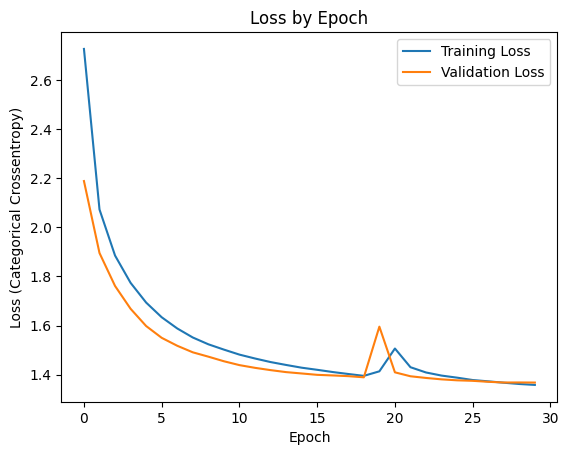

In [19]:
with open(HISTORY_PATH, "rb") as infile:
    history = pickle.load(infile)

fig, ax = plt.subplots()
ax.plot(history["loss"], label="Training Loss")
ax.plot(history["val_loss"], label="Validation Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (Categorical Crossentropy)")
ax.set_title("Loss by Epoch")
ax.legend()
plt.show()

In [20]:
lstm_model = keras.models.load_model(MODEL_PATH)
print("loaded model")

with open(VECTORIZER_PATH, "rb") as infile:
    vectorizer = pickle.load(infile)
print("loaded vectorizer")

loaded model
loaded vectorizer


### 3.5 Evaluate the model with per-class accuracy

In [21]:
# Instantiate dictionaries to keep track of errors
num_correct_by_idx = {k:0 for k in vectorizer.int_to_token_mapping.keys()}
total_count_by_idx = {k:0 for k in vectorizer.int_to_token_mapping.keys()}

# Iterate over the batches in the testing data, and count
# how many predictions are correctly made
for batch_samples, batch_labels in testing_dataset:
    gold_labels = batch_labels.numpy().argmax(axis=1)
    predictions = lstm_model(batch_samples).numpy().argmax(axis=1)
    for i in range(len(gold_labels)):
        label = gold_labels[i]
        total_count_by_idx[label] += 1
        # If the model prediction is correct, count it
        if label == predictions[i]:
            num_correct_by_idx[label] += 1

# Compute how many predictions of each character were actually correct           
pct_correct_by_idx = {
    idx:(num_correct_by_idx[idx]/total_count_by_idx[idx])
    for idx in num_correct_by_idx.keys()
    if total_count_by_idx[idx] != 0
}

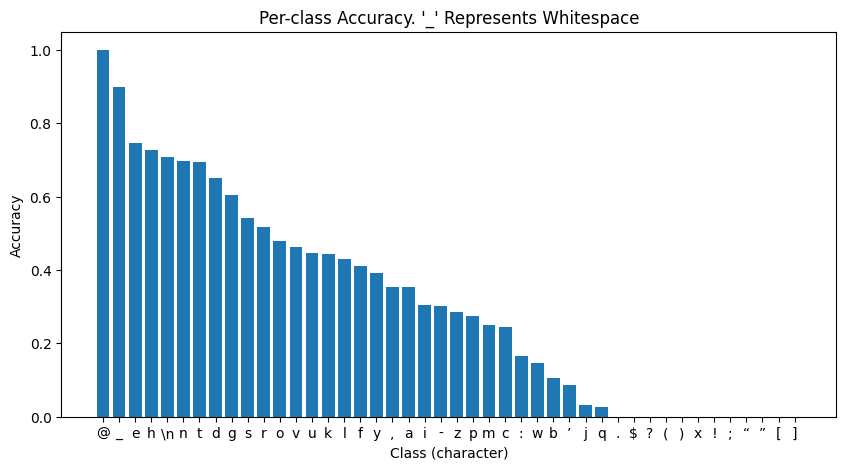

In [22]:
# Compute how many predictions of each character were actually correct    
pct_correct_by_char = {
    vectorizer.int_to_token(i):pct for i,pct in pct_correct_by_idx.items()
}

labels = list(sorted(pct_correct_by_char, key=pct_correct_by_char.get, reverse=True))
pct_correct = [pct_correct_by_char[char] for char in labels]
labels[labels.index(" ")] = "_"
labels[labels.index("\n")] = "\\n"

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(labels, pct_correct)
ax.set_title("Per-class Accuracy. '_' Represents Whitespace")
ax.set_xlabel("Class (character)")
ax.set_ylabel("Accuracy")

plt.show()


### 3.6 Generate a poem

In [44]:
def generate_poem(model, seed, vectorizer, max_length):
    """Generate a poem using a LSTM neural language model
    
    Parameters:
        model (keras.Sequential):
            Trained LSTM neural network
        seed (str):
            The beginning of a poem, to get the model started
        vectorizer (Vectorizer):
            Vectorizer fit to the vocabulary of the model and seed
        max_length (int):
            Maximum number of characters in the poem
    
    Returns:
        str: A poem
    """
    seed_chars = list(seed)
    for i in range(0, max_length):
        # Vectorize the seed phrase and give it the shape:
        # (batch_size, seq_length, vocab_size)
        vec = (vectorizer
               .tokens_to_vectors(seed_chars)
               .reshape(1, len(seed_chars), vectorizer.vocab_size()))

        # Ask the model for a prediction on the current seed phrase
        pred_distribution = model(vec)[0].numpy()

        # Make a choice over the probability distribution, like in the Shannon method
        options = list(range(0, vectorizer.vocab_size()))
        idx = np.random.choice(options, p=pred_distribution)

        # Turn the chosen value into a character and append it to the seed
        char = vectorizer.int_to_token(idx)
        seed_chars.append(char)

        # If the character is one of the poem segmenting symbols, end early
        if char in ["@", "$"]:
            break
    return "".join(seed_chars)


---

## 4. Comparing Generated Poems from N-gram LM and Recurrent Neural LM

Generate 3 poems from each type of model and conduct a qualitative analysis on their differences

In [54]:
ngram_lm_poems = [
    postprocess_for_ngram_lm(ngram_model.generate_poem(max_words=50))
    for _ in range(3)
]

seed_phrases = ["i sing a song of myself ", "cool afternoon breeze ", "sitting outside "]
neural_lm_poems = [
    postprocess_for_neural_lm(generate_poem(lstm_model, s, vectorizer, max_length=250))
    for s in seed_phrases
] 

'\nseed_phrases = ["i sing a song of myself ", "cool afternoon breeze ", "sitting outside "]\nneural_lm_poems = [\n    postprocess_for_neural_lm(generate_poem(lstm_model, s, vectorizer, max_length=250))\n    for s in seed_phrases\n] \n'

#### N-Gram Language Model Poems

In [55]:
for i, ngram_lm_poem in enumerate(ngram_lm_poems):
    print(f"Poem {i+1}")
    print(ngram_lm_poem)
    print()

Poem 1
how they are not denied ; 
 with my material

Poem 2
i am the cent ; ) 
 but out of the

Poem 3
1
 a song for the great lakes , 
 these



#### LSTM Language Model Poems

In [53]:
for i, lstm_lm_poem in enumerate(neural_lm_poems):
    print(f"Poem {i+1}")
    print(lstm_lm_poem)
    print()

Poem 1
i sing a song of myself too a noisted
 far, blow, intine poor, planets,
 and take to you dead and convulsive for you i nowning the
 officars.$

Poem 2
cool afternoon breeze and wat, tell to ack and ship,
 from a waves sexes dufflands underthispers at man passed by the busles,
 of no, i not amid pacific, lacking, man,) breathes at my dark and
 firghen,
 pight by the bear sleeper around the soul,
 without pine, a

Poem 3
sitting outside in its,
 you speak to-day, to afternoon and from afterward is clusters,
 the all, fatter sacred races and death.

 always pensive is and unferts as flashing to watch my arms, towers,
 the soul female carment, and begin wine?$



### 4.1 Discussion

Lorum Ipsum